## A notebook to test some (but not all) aspects of python environment

The code here is outdated and potentially incorrect as it was quickly written just to make sure certain packages worked. Do NOT use for actual analyses.

In [7]:
import logging
import os
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyro
from embo import InformationBottleneck

import pyro.distributions as dist
import pyro.distributions.constraints as constraints

import glob, ndd, pickle

In [8]:
# THE CODE IN THIS NOTEBOOK IS GENERALLY OUTDATED AND NOT IMPLEMENTED CORRECTLY, SO IT SHOULDN'T BE USED FOR FUTURE ANALYSES
# IT IS PURELY TO TEST THAT THE PYTHON ENVIRONMENT WORKS

cmap = plt.get_cmap("tab10")

wsize = 7
wsize_ib = 7

# def get_windowed_x_no_offset(x,z,w=1,base=2):
#     zw = z[w-1:].copy()
#     aux_base = base**np.arange(w)
#     xw_binned = np.array([sum(aux_base*np.array(x[i:(i+w)])) for i in np.arange(len(zw))])
#     return(xw_binned,zw)

class generator:
    
    def __init__(self,p,h):
        # this is only defined for two states and two observation types, with symmetric emission and transition probabilities
        self.p = p # probability of observation 0 for state 0 and observation 1 for state 1
        self.h = h # probability of transition to other state on a given trial
        
    def gen_trial_seq(self,n):
        states = np.empty((n))
        obs = np.empty((n))
        
        state_cur = np.random.choice([0,1])
        for i in range(n):
            states[i] = state_cur
            if np.random.uniform() < self.p:
                obs[i] = state_cur
            else:
                obs[i] = 1-state_cur
                
            if np.random.uniform() < self.h:
                state_cur = 1-state_cur
                
        return states.astype(int), obs.astype(int)

def mutual_inf_nsb(x,y,ks):
    """
    Calculate mutual information using NSB method
    """
    ar = np.column_stack((x,y))
    mi = ndd.mutual_information(ar,ks)
    return np.log2(np.e)*mi #ndd returns nats - multiply by log2(e) to convert to bits

def get_windowed_mi(x,z,wsize,offset=1):
    '''
    Function that windows of observations from a sequence x offset from y and computes the MI
    Input:
        - x: sequence of "past" observations to be windowed
        - z: sequence that serves as the "future" events
        - wsize: window size
    Output:
        - mis: NSB estimated mutual information for windowed data
    '''
    # mi = np.zeros(nw+1) #vector of mutual informations for different window sizes
    xw,zw = get_windowed_x(x,z,w=wsize,offset=offset) # use convenience function from utilities to window x
    mi = mutual_inf_nsb(xw,zw,[2**wsize,2]) # use convenience function from utilities to compute NSB mutual info
#     for w in np.arange(1,nw+1):
#         xw,zw = ut.get_windowed_x(x,z,w=w)         # use convenience function from utilities to window x
#         mis[w] = ut.mutual_inf_nsb(xw,zw,[2**w,2]) # use convenience function from utilities to compute NSB mutual info
    return(mi)

def get_windowed_x(x,z,w=1,base=2,offset=1):
    zw = z[w-1+offset:].copy()
    aux_base = base**np.arange(w)
    xw_binned = np.array([sum(aux_base*np.array(x[i:(i+w)])) for i in np.arange(len(zw))])
    return(xw_binned,zw)

def get_windowed_bound_corrected(sdf,wsize,trimN=0,mb=50,nb=2000,p=8,base=2):
    # xw,zw = ut.get_windowed_x(x,z,w=w,base=base)
    # lists of windowed x and windowed z
    xws = []
    zws = []
    xw1s = []
    zw1s = []
    for subi,sub in enumerate(pd.unique(sdf['Subject'])):
        sdat = sdf.loc[sdf['Subject'] == sub].copy()
        xw,zw = get_windowed_x(sdat['Bead'].to_numpy()[trimN:]-1,sdat['Bead'].to_numpy()[trimN:]-1,w=wsize,base=base)
        xw1,zw1 = get_windowed_x(sdat['Bead'].to_numpy()[trimN:]-1,sdat['Bead'].to_numpy()[trimN:]-1,w=1,base=base)
        xws.append(xw)
        zws.append(zw)
        xw1s.append(xw1)
        zw1s.append(zw1)
    xw_all = np.concatenate(tuple(xws),axis=0)
    zw_all = np.concatenate(tuple(zws),axis=0)
    xw1_all = np.concatenate(tuple(xw1s),axis=0)
    zw1_all = np.concatenate(tuple(zw1s),axis=0)
    ipw,ifw,hpw_,betasw = InformationBottleneck(xw_all,zw_all,minsize=True,processes=p,maxbeta=mb,numbeta=nb).get_empirical_bottleneck()
    ip1b,if1b,hp1b_,betas1b = InformationBottleneck(xw1_all,zw1_all,minsize=True,processes=p,maxbeta=mb,numbeta=nb).get_empirical_bottleneck()
    return((ipw,ifw,ip1b,if1b))

def get_windowed_bound_jar_corrected(sdf,wsize,trimN=0,mb=50,nb=2000,p=8,base=2):
    # xw,zw = ut.get_windowed_x(x,z,w=w,base=base)
    # lists of windowed x and windowed z
    xws = []
    zws = []
    xw1s = []
    zw1s = []
    for subi,sub in enumerate(pd.unique(sdf['Subject'])):
        sdat = sdf.loc[sdf['Subject'] == sub].copy()
        xw,zw = get_windowed_x(sdat['Bead'].to_numpy()[trimN:]-1,sdat['Jar'].to_numpy()[trimN:]-1,w=wsize,base=base,offset=0)
        xw1,zw1 = get_windowed_x(sdat['Bead'].to_numpy()[trimN:]-1,sdat['Jar'].to_numpy()[trimN:]-1,w=1,base=base,offset=0)
        xws.append(xw)
        zws.append(zw)
        xw1s.append(xw1)
        zw1s.append(zw1)
    xw_all = np.concatenate(tuple(xws),axis=0)
    zw_all = np.concatenate(tuple(zws),axis=0)
    xw1_all = np.concatenate(tuple(xw1s),axis=0)
    zw1_all = np.concatenate(tuple(zw1s),axis=0)
    ipw,ifw,hpw_,betasw = InformationBottleneck(xw_all,zw_all,minsize=True,processes=p,maxbeta=mb,numbeta=nb).get_empirical_bottleneck()
    ip1b,if1b,hp1b_,betas1b = InformationBottleneck(xw1_all,zw1_all,minsize=True,processes=p,maxbeta=mb,numbeta=nb).get_empirical_bottleneck()
    return((ipw,ifw,ip1b,if1b))

def get_windowed_sub_mis(sdf,wsize,trimN=0):
    '''
    Function to compute windowed mutual information values for all subjects
    Input:
        - sdf: data frame with all of the subject tones, responses, and sources
        - wsize: window size
    Output:
        - Ipast for each window size and Ifuture
    '''
    # Create dictionaries to keep track of variables with subject IDs as the keys
    ip_sub = []
    if_sub = []
    # Loop through each subject and get their Ipast for windows up to nw and their ifuture
    for subi,sub in enumerate(pd.unique(sdf['Subject'])):
        sdat = sdf.loc[sdf['Subject'] == sub].copy()                     # Get data from specific subject 
        ip_sub.append(get_windowed_mi(sdat['Bead'].to_numpy()[trimN:]-1,sdat['Resp01'].to_numpy()[trimN:],wsize))  # compute Ipast using function defined above 
        if_sub.append(mutual_inf_nsb(sdat['Resp01'].to_numpy()[trimN:],sdat['Bead'].to_numpy()[trimN:]-1,[2,2]))   # compute Ifuture
    # Return dictionaries of ipast and ifuture values
    return(np.array(ip_sub),np.array(if_sub))

def get_windowed_sub_mis_alt(sub_preds,beads,wsize,trimN=0):
    '''
    Function to compute windowed mutual information values for all subjects
    Input:
        - sdf: data frame with all of the subject tones, responses, and sources
        - wsize: window size
    Output:
        - Ipast for each window size and Ifuture
    '''
    ip_sub = get_windowed_mi(beads[trimN:]-1,sub_preds[trimN:],wsize)
    if_sub = mutual_inf_nsb(sub_preds[trimN:],beads[trimN:]-1,[2,2])

    return (ip_sub, if_sub)

def get_windowed_sub_mis_jar(sdf,wsize,trimN=0):
    '''
    Function to compute windowed mutual information values for all subjects
    Input:
        - sdf: data frame with all of the subject tones, responses, and sources
        - wsize: window size
    Output:
        - Ipast for each window size and Ifuture
    '''
    # Create dictionaries to keep track of variables with subject IDs as the keys
    ip_sub = []
    if_sub = []
    # Loop through each subject and get their Ipast for windows up to nw and their ifuture
    for subi,sub in enumerate(pd.unique(sdf['Subject'])):
        sdat = sdf.loc[sdf['Subject'] == sub].copy()                     # Get data from specific subject 
        ip_sub.append(get_windowed_mi(sdat['Bead'].to_numpy()[trimN:]-1,sdat['Resp01'].to_numpy()[trimN:],wsize))  # compute Ipast using function defined above 
        if_sub.append(mutual_inf_nsb(sdat['Resp01'].to_numpy()[trimN:],sdat['Jar'].to_numpy()[trimN-1:-1]-1,[2,2]))   # compute Ifuture
    # Return dictionaries of ipast and ifuture values
    return(np.array(ip_sub),np.array(if_sub))

def get_windowed_bound(x,z,w,mb=50,nb=2000,p=8,base=2,offset=1):
    '''
    Function that computes the information bottleneck bound between two discrete variables
    Input:
        - x: sequence of past events
        - z: sequence of future events
        - w: size of the window to be applied to x
        - mb: maximum value of the lagrange multiplier beta
        - nb: number of values of beta between 0 and mb to be run through the Blahaut-Arimoto algorithm
        - p: number of cores to use in the computation (to help with speed)
    Output:
        - 4 element tuple with a sequence of ipast and ifuture values corresponding to the information bottleneck for full and one back bounds
    '''
    # Get desired windowed x and corresponding z
    xw,zw = get_windowed_x(x,z,w=w,base=base,offset=offset)
    
    # Compute the information bottleneck using EMBO for the window size w specified above
    ipw,ifw,hpw_,betasw = InformationBottleneck(xw,zw,minsize=True,processes=p,maxbeta=mb,numbeta=nb).get_empirical_bottleneck() 
    
    # Compute the information bottleneck using EMBO for the window size w specified above
    x1b,z1b = get_windowed_x(x,z,w=1,base=base,offset=offset)
    ip1b,if1b,hp1b_,betas1b = InformationBottleneck(x1b,z1b,minsize=True,processes=p,maxbeta=mb,numbeta=nb).get_empirical_bottleneck() 
   
    # Return informtion bottleneck
    return((ipw,ifw,ip1b,if1b))

class agent:
    
    def __init__(self, agent_type):
        self.agent_type = agent_type
        
    def gen_pred_probs(self,beads,jars):
        # define this in child classes
        # this function generates raw prediction probabilities or values, upon which predictions are based
        # doing it this way makes it easier to do things like add noise
        self.pred_probs = np.empty((2,len(beads)))
        self.pred_probs[:] = np.nan
    
    def gen_hard_preds(self):
        # hardmax prediction
        maxes = np.max(self.pred_probs,axis=0) # compute maxes (can't use argmax here - see below)
        # compute the indices of each max for each trial, which corresponds to the bead to predict
        minds = [np.nonzero(self.pred_probs[:,i] == maxes[i]) for i in range(self.pred_probs.shape[1])]
        # take index as prediction if max is unique or randomly choose among the indices when the max is not unique
        ### MINDS CAN HAVE EMPTY ELEMENTS IF SELF.PRED_PROBS HAS EMPTY VALUES
        self.hard_preds = [np.nan if len(minds[i][0]) == 0 else minds[i][0][0] if len(minds[i][0])==1 else np.random.choice(minds[i][0]) for i in  range(self.pred_probs.shape[1])]
        
    def get_hard_preds(self):
        return self.hard_preds
    
    def gen_noisy_probs(self,noises=[100,10,5,2,1,.5]):
        self.noisy_probs = [np.zeros((self.pred_probs.shape[1],len(noises)))] * len(noises)
        self.noises = noises
        for ni, noise in enumerate(noises):
            # apply a softmax transformation to the probabilities
            self.noisy_probs[ni] = np.exp(noise * self.pred_probs) / np.sum(np.exp(noise * self.pred_probs),axis=0)
        
    def gen_noisy_preds(self):
        self.noisy_preds = np.zeros((self.noisy_probs[0].shape[1],len(self.noisy_probs)))
        for ip, pred_probs in enumerate(self.noisy_probs):
            # using the noisy probs for each bead, create a CDF for each trial
            noisy_cdfs = np.cumsum(pred_probs,axis=0)
            # compare CDF for each trial to a draw from a uniform[0,1) that is specific to each trial
            # this generates the noisy prediction
            rands = np.random.default_rng().uniform(size=(1,pred_probs.shape[1]))
            self.noisy_preds[:,ip] = np.array([np.nan if np.isnan(pred_probs[0,i]) else (np.nonzero(rands[0,i]<noisy_cdfs[:,i])[0][0]) for i in range(noisy_cdfs.shape[1])]).squeeze()
            
    def get_noisy_preds(self):
        return self.noisy_preds
    
    def calc_hard_mis(self,beads,jars,window_size=10,base=2):
        # generate variables for observed bead sequence and next bead based on given window size
        xw,yw = get_windowed_x(beads,beads,w=window_size,base=base)
        #self.hard_ip = mutual_inf_nsb(xw,self.hard_preds[window_size:],[base**window_size,2]) # compute Ipast
        #self.hard_if = mutual_inf_nsb(self.hard_preds[window_size:],yw,[2,2]) # compute Ifuture
        self.hard_ip = mutual_inf_nsb(xw,self.hard_preds[window_size-1:-1],[base**window_size,2]) # compute Ipast
        self.hard_if = mutual_inf_nsb(self.hard_preds[window_size-1:-1],yw,[2,2]) # compute Ifuture
        
    def calc_noisy_mis(self,beads,jars,window_size=10,base=2):
        self.noisy_ips = np.zeros((len(self.noises)))
        self.noisy_ifs = np.zeros((len(self.noises)))
        xw,yw = get_windowed_x(beads,beads,w=window_size,base=base)
        for ix in range(len(self.noises)):
            #self.noisy_ips[ix] = mutual_inf_nsb(xw,self.noisy_preds[window_size:,ix],[base**window_size,2]) # compute Ipast
            #self.noisy_ifs[ix] = mutual_inf_nsb(self.noisy_preds[window_size:,ix],yw,[2,2]) # compute Ipast
            self.noisy_ips[ix] = mutual_inf_nsb(xw,self.noisy_preds[window_size-1:-1,ix],[base**window_size,2]) # compute Ipast
            self.noisy_ifs[ix] = mutual_inf_nsb(self.noisy_preds[window_size-1:-1,ix],yw,[2,2]) # compute Ipast
            
    def plot_ib_curve(self,ips,ifs,ips1b,ifs1b):
        self.fig1, self.axs1 = plt.subplots(1,1)
        self.axs1.plot(ips,ifs,'-k')
        self.axs1.plot(ips1b,ifs1b,'--k')
        self.axs1.plot(self.noisy_ips,self.noisy_ifs,color='gray', marker='o',linestyle='')
        self.axs1.plot(self.hard_ip,self.hard_if,color='black', marker='o')
    
    def all_analyses(self,beads,jars,ips,ifs,ips1b,ifs1b,window_size=10,base=2,noises=[100,10,5,2,1,.5]):
        # a method to compute all measures above and make plots
        self.gen_pred_probs(beads,jars)
        self.gen_hard_preds()
        self.gen_noisy_probs(noises=noises)
        self.gen_noisy_preds()
        self.calc_hard_mis(beads,jars,window_size=window_size,base=base)
        self.calc_noisy_mis(beads,jars,window_size=window_size,base=base)
        self.plot_ib_curve(ips,ifs,ips1b,ifs1b)
        
class bayes(agent):
    
    def __init__(self,p,h,P0=np.array([0.5,0.5])):
        super().__init__('bayes')
        self.p = p
        self.h = h
        self.P0 = P0
        
    def gen_pred_probs_EXP(self,beads,jars,P0=np.array([0.5,0.5])):
        # bayes optimal integration over all past beads
        # this version doesn't work, likely because of poorly defined matrix operations
        self.pred_probs = np.zeros((2,len(beads)))
        h = self.h
        p = self.p
        H = np.array([[1-h,h],[h,1-h]])
        E = np.array([[p,1-p],[1-p,p]])
        # Lseq = E[beads]
        Pseq = np.zeros((2,len(beads)))
        Lseq = np.zeros((2,len(beads)))
        for ib in range(len(beads)):
            Lseq[:,ib] = E[beads[ib]]
            Pjoint = np.linalg.matrix_power(H,ib) @ P0 * np.prod(np.vstack(Lseq[:ib+1]), axis=1)
            Pseq[:,ib] = Pjoint / np.sum(Pjoint)
            self.pred_probs[:,ib] = E @ H @ Pseq[:,ib]
        # self.pred_probs[:,ib] = E @ H @ Pseq
                        
    def gen_pred_probs(self,beads,jars):
        self.pred_probs = np.zeros((2,len(beads)))
        self.pred_probs[:] = np.nan
        h = self.h
        p = self.p
        H = np.array([[1-h,h],[h,1-h]])
        E = np.array([[p,1-p],[1-p,p]])
        Plast = self.P0.copy()
        for ib in range(len(beads)):
            L = E[beads[ib]]
            Pcurr = (H @ Plast * L) / (np.sum(H @ Plast * L))
            self.pred_probs[:,ib] = E @ H @ Pcurr
            Plast = Pcurr.copy()
            
    def gen_pred_probs_orig(self,beads,jars):
        self.pred_probs = np.zeros((2,len(beads)))
        h = self.h
        p = self.p
        # Pseq = np.zeros((2,len(beads)))
        p_jars = self.P0.copy()
        likes = np.array([[p,1-p],[1-p,p]])
        H = np.array([[1-h,h],[h,1-h]])
        E = np.array([[p,1-p],[1-p,p]])
        for ib in range(len(beads)):
            z1,z2 = tuple(p_jars.copy())
            p_jars = [(1-h)*z1 + h*z2, (1-h)*z2 + h*z1]
            p_jars = p_jars*likes[int(beads[ib])]
            p_jars = p_jars/sum(p_jars)
            self.pred_probs[:,ib] = E @ H @ p_jars
            
    def gen_prob_match_preds(self):
        cdfs = np.cumsum(self.pred_probs,axis=0)
        rands = np.random.default_rng().uniform(size=(1,self.pred_probs.shape[1]))
        self.prob_match_preds = np.array([np.nan if np.isnan(self.pred_probs[0,i]) else (np.nonzero(rands[0,i]<cdfs[:,i])[0][0]) for i in range(cdfs.shape[1])]).squeeze()
        
    def calc_prob_match_mis(self,beads,jars,window_size=10,base=2):
        # generate variables for observed bead sequence and next bead based on given window size
        xw,yw = get_windowed_x(beads,beads,w=window_size,base=base)
        self.pm_ip = mutual_inf_nsb(xw,self.prob_match_preds[window_size-1:-1],[base**window_size,2]) # compute Ipast
        self.pm_if = mutual_inf_nsb(self.prob_match_preds[window_size-1:-1],yw,[2,2]) # compute Ifuture
        
    def plot_ib_curve_2(self,ips,ifs,ips1b,ifs1b):
        fig, axs = plt.subplots(1,1)
        axs.plot(ips,ifs,'-k')
        axs.plot(ips1b,ifs1b,'--k')
        axs.plot(self.noisy_ips,self.noisy_ifs,color='gray', marker='o',linestyle='')
        axs.plot(self.hard_ip,self.hard_if,color='black', marker='o')
        axs.plot(self.pm_ip, self.pm_if, marker='o')

class windowed_bayes(agent):
    
    def __init__(self,p,h,window,P0=np.array([0.5,0.5])):
        super().__init__('windowed_bayesian')
        self.window = window
        self.p = p
        self.h = h
        self.P0 = P0
        
    def gen_pred_probs(self,beads,jars):
        # use bayesian integration over a specified window of past beads
        self.pred_probs = np.ones((2,len(beads)))
        H = np.array([[1-self.h,self.h],[self.h,1-self.h]])
        E = np.array([[self.p,1-self.p],[1-self.p,self.p]])
        for ic in range(len(beads)-self.window):
            chunk = beads[ic:ic+self.window]
            Plast = self.P0.copy()
            if ic == 0:
                print(f'{Plast[1]:.3f} \n')
            for ib in range(len(chunk)):
                L = E[chunk[ib]]
                Pcurr = (H @ Plast * L) / (np.sum(H @ Plast * L))
                if ic == 0:
                    print(f'{Pcurr[1]:.3f}')
                Plast = Pcurr.copy()
            self.pred_probs[:,ic+self.window-1] = E @ H @ Pcurr
            if ic == 0:
                print(f'\n{self.pred_probs[1,ic+self.window-1]:.3f}')
        
        # pad beginning of probs with NaNs (when the number of seen beads is less than the window size)
        # self.pred_probs = np.concatenate((np.ones((2,self.window-1)),self.pred_probs),axis=1)
        assert(self.pred_probs.shape[1] == len(beads))

def simulated_dataset(N,beads,jars,wsize):
    pred_mat = np.empty((N,len(beads)))
    ip_vec = np.empty((N,1))
    if_vec = np.empty((N,1))
    for ii in range(N):
        noise = np.random.choice(np.arange(20))
        sub = windowed_bayes(0.8,0.01,window=wsize)
        sub.gen_pred_probs(beads,jars)
        sub.gen_noisy_probs(noises=[noise])
        sub.gen_noisy_preds()
        sub.calc_noisy_mis(beads,jars,window_size=wsize)

        pred_mat[ii,:] = sub.noisy_preds[0]
        ip_vec[ii] = sub.noisy_ips[0]
        if_vec[ii] = sub.noisy_ifs[0]
    return (pred_mat, ip_vec, if_vec)

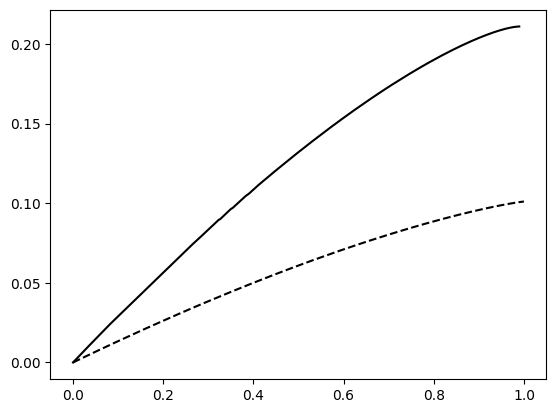

In [9]:
# compute IB bound over many trials

def gen_trial_seq(n,h,P):
    states = np.empty((n))
    obs = np.empty((n))
        
    state_cur = np.random.choice([0,1])
    for i in range(n):
        states[i] = state_cur
        if np.random.uniform() < P[state_cur]:
            obs[i] = state_cur
        else:
            obs[i] = 1-state_cur
                
        if np.random.uniform() < h:
            state_cur = 1-state_cur
                
    return states.astype(int), obs.astype(int)

n = 10000
h = 0.01
# P = [0.9, 0.7]
P = [0.8, 0.8]

jars, beads = gen_trial_seq(n,h,P)

ipw,ifw,ipw1b,ifw1b = get_windowed_bound(beads,beads,wsize_ib)

plt.plot(ipw,ifw,'-k')
plt.plot(ipw1b, ifw1b, '--k')

([], [])

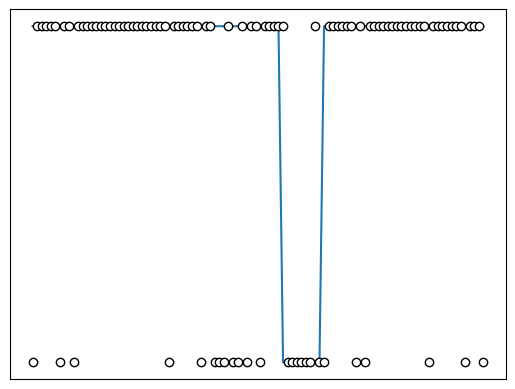

In [10]:
# generate trial sequence for fake data

n = 500

hm_env = generator(0.8,0.01)
m_env = generator(1,0.32)

hm_jars, hm_beads = hm_env.gen_trial_seq(n)
m_jars, m_beads = m_env.gen_trial_seq(n)

plt.plot(hm_jars[:100],color=cmap(0))
plt.plot(hm_beads[:100],'o',mec='black',mfc='white')
plt.xticks([])
plt.yticks([])

In [11]:
pred_mat, ip_vec, if_vec = simulated_dataset(50,hm_beads,hm_jars,wsize=wsize)

0.500 

0.200
0.509
0.806
0.941
0.982
0.993
0.936

0.756
0.500 

0.200
0.509
0.806
0.941
0.982
0.993
0.936

0.756
0.500 

0.200
0.509
0.806
0.941
0.982
0.993
0.936

0.756
0.500 

0.200
0.509
0.806
0.941
0.982
0.993
0.936

0.756
0.500 

0.200
0.509
0.806
0.941
0.982
0.993
0.936

0.756
0.500 

0.200
0.509
0.806
0.941
0.982
0.993
0.936

0.756
0.500 

0.200
0.509
0.806
0.941
0.982
0.993
0.936

0.756
0.500 

0.200
0.509
0.806
0.941
0.982
0.993
0.936

0.756
0.500 

0.200
0.509
0.806
0.941
0.982
0.993
0.936

0.756
0.500 

0.200
0.509
0.806
0.941
0.982
0.993
0.936

0.756
0.500 

0.200
0.509
0.806
0.941
0.982
0.993
0.936

0.756
0.500 

0.200
0.509
0.806
0.941
0.982
0.993
0.936

0.756
0.500 

0.200
0.509
0.806
0.941
0.982
0.993
0.936

0.756
0.500 

0.200
0.509
0.806
0.941
0.982
0.993
0.936

0.756
0.500 

0.200
0.509
0.806
0.941
0.982
0.993
0.936

0.756
0.500 

0.200
0.509
0.806
0.941
0.982
0.993
0.936

0.756
0.500 

0.200
0.509
0.806
0.941
0.982
0.993
0.936

0.756
0.500 

0.200
0.509
0.806
0.941

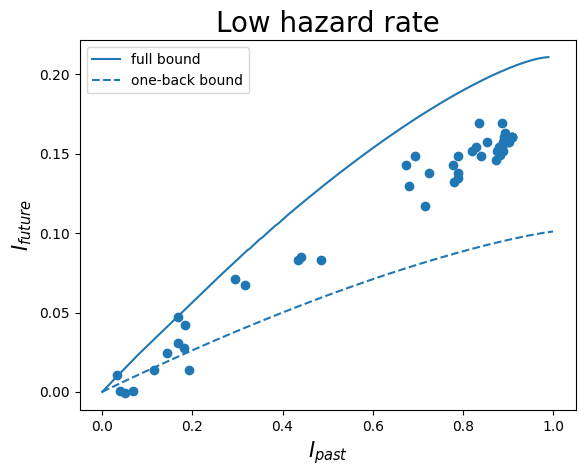

In [12]:
plt.plot(ipw,ifw,'-',color=cmap(0),label='full bound')
plt.plot(ipw1b,ifw1b,'--',color=cmap(0), label='one-back bound')
plt.plot(ip_vec, if_vec,'o',color=cmap(0))
plt.xlabel('$I_{past}$',size=15)
plt.ylabel('$I_{future}$',size=15)
plt.title('Low hazard rate',size=20)
plt.legend()